In [1]:
import logging
logging.root.setLevel(logging.INFO)


In [2]:
import random

from xcs import XCSAlgorithm
from xcs.scenarios import Scenario

In [3]:
from utils.xcs_utils import *

In [4]:
exploration_cycles = 1000
exploitation_cycles = 500
input_size = 8
logging.root.setLevel(logging.INFO)
scenario = MazeScenario(input_size)
scenario.maze.reset()
scenario.maze.render()


■ ■ ■ ■ ■ ■ ■ ■
■ □ □ ■ □ □ $ ■
■ ■ □ □ ■ □ □ ■
■ ■ □ ■ □ □ ■ ■
■ □ □ □ A □ □ ■
■ ■ □ ■ □ □ □ ■
■ □ □ □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■


In [5]:
import numpy as np
algorithm = XCSAlgorithm()
algorithm.max_population_size = 1600
algorithm.learning_rate = .1
algorithm.error_threshold = .01              # epsilon_0
algorithm.ga_threshold = 25
algorithm.crossover_probability = 1
algorithm.mutation_probability = 0.01
algorithm.initial_prediction = 0.000001               # p_I
algorithm.initial_error = 0.000001            # epsilon_I
algorithm.initial_fitness = 0.000001           # F_I
algorithm.wildcard_probability = 0.0

In [6]:
other_metrics = other_avg_experiment(
                                     maze=scenario,
                                     algorithm=algorithm,
                                     number_of_tests=1,
                                     explore_trials=exploration_cycles,
                                     exploit_trials=exploitation_cycles
                                    )


Executing 0 experiment


In [7]:
display(other_metrics)

,steps_in_trial,population,numerosity
trial,,,
0,50,48,48
100,11,356,1600
200,50,406,1600
300,21,463,1600
400,50,459,1600
500,50,430,1600
600,48,487,1600
700,50,495,1600
800,50,501,1600


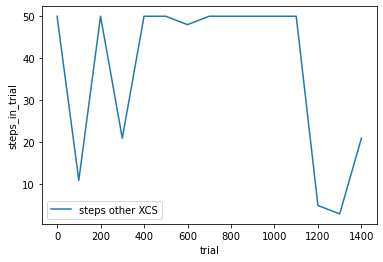

In [8]:
import pandas as pd

ax = other_metrics["steps_in_trial"].plot()
ax.set_xlabel("trial")
ax.set_ylabel("steps_in_trial")
ax.legend(["steps other XCS"])

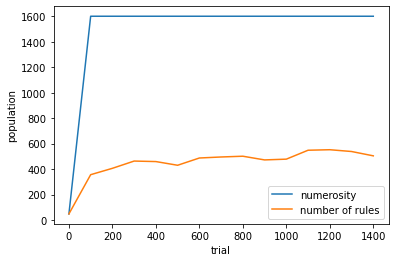

In [9]:
ax = other_metrics[['numerosity', 'population']].plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["numerosity", "number of rules"])

In [10]:
from lcs.agents.xcs import Configuration
from utils.xcs_utils import *
                    

cfg = Configuration(number_of_actions=8,
                    max_population=1600,
                    covering_wildcard_chance = 1,
                    ga_threshold = 25,
                    metrics_trial_frequency=100,
                    mutation_chance=0.03,
                    chi=1,                           # crossover
                    initial_prediction = 0.000001,               # p_I
                    initial_error = 0.000001,            # epsilon_I
                    initial_fitness = 0.000001,           # F_I
                    user_metrics_collector_fcn=xcs_metrics)

In [11]:
from lcs.agents.xcs import XCS


agent = XCS(cfg)
my_metrics = avg_experiment(scenario,
                    cfg,
                    number_of_tests=1,
                    explore_trials=exploration_cycles,
                    exploit_metrics=exploitation_cycles)


INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': [4.853293400638485e-09, 1.5513008505456238e-08, 4.853293400638485e-09, 1.0666607281520895e-08, 1.1330331416714414e-08, 2.25638247058798e-08, 2.3519964529236892e-08, 1.4966103277479953e-08], 'perf_time': 0.014919000000006122, 'population': 80, 'numerosity': 80}


Executing 0 experiment


INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 35, 'reward': [20.72817337478072, 150.34470800498298, 17.841370537799342, 21.211367711060426, 24.757264794946533, 19.664738591081985, 30.485395490220334, 24.808342688869462], 'perf_time': 0.06060149999998998, 'population': 329, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 36, 'reward': [57.54307373548139, 43.10794007818909, 148.96376212111437, 31.749378240500242, 50.72326620400441, 42.606363769847434, 49.943004843631385, 35.90668008392791], 'perf_time': 0.08095700000001216, 'population': 361, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 300, 'steps_in_trial': 19, 'reward': [65.69862693774058, 169.062476389856, 54.914263901857694, 59.23680565948616, 73.9389692709207, 75.2763929881259, 67.51153007914898, 74.68218691446816], 'perf_time': 0.0511620999999991, 'population': 384, 'numerosity': 1600}
INFO:lcs.agents.Agent:{'trial': 400, 'steps_in_trial': 14, 'reward': [184.88413944823566, 71.64299250573

In [12]:
display(my_metrics)

,steps_in_trial,perf_time,population,numerosity
trial,,,,
0,50,0.014919,80,80
100,35,0.060601,329,1600
200,36,0.080957,361,1600
300,19,0.051162,384,1600
400,14,0.030656,397,1600
500,50,0.110061,409,1600
600,50,0.117091,418,1600
700,19,0.044011,415,1600
800,6,0.013663,408,1600


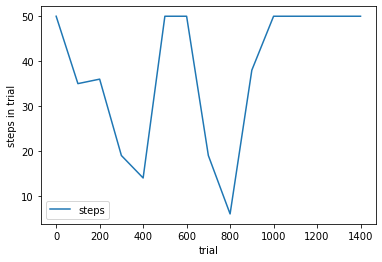

In [13]:
import pandas as pd

ax = my_metrics['steps_in_trial'].plot()
ax.set_xlabel("trial")
ax.set_ylabel("steps in trial")
ax.legend(["steps"])


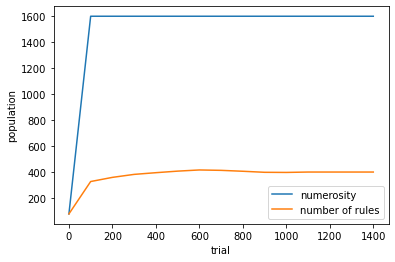

In [14]:
ax = my_metrics[['numerosity', 'population']].plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["numerosity", "number of rules"])

#### Conclusions
None so far.